## Recommender System with Neural Network and Text CNN
For this model, we use the movielens data.
https://grouplens.org/datasets/movielens/
MovieLens 1M Dataset
Because only this data have users data. The data with greater size do not have that.

The reason for us to build this neural network is the business model to find good moive components.
However, we tried Naive Bayes and Decision tree, both of the models have large overfitting. The training models are highly effected by the partition of training datasets. And because of we don't have enough data about actors and other informations. This models can not use in this situation.

So we turned to give every movie a rating from every user by some models. And by analyzing this rating martix and merge with the datasets with that attributes about other films information. By counting the ratings that higher than some values of any combinations of attributes.

The main idea is to extract feature from user table and movie table. and base on the feature, we combine them together and get the ratings for every movie by every user. and compare the ratings we get and the real rating data in our database, then refine our model to get a lower MSE.

Based on that we build a neural network as below.

### Neural Network Design
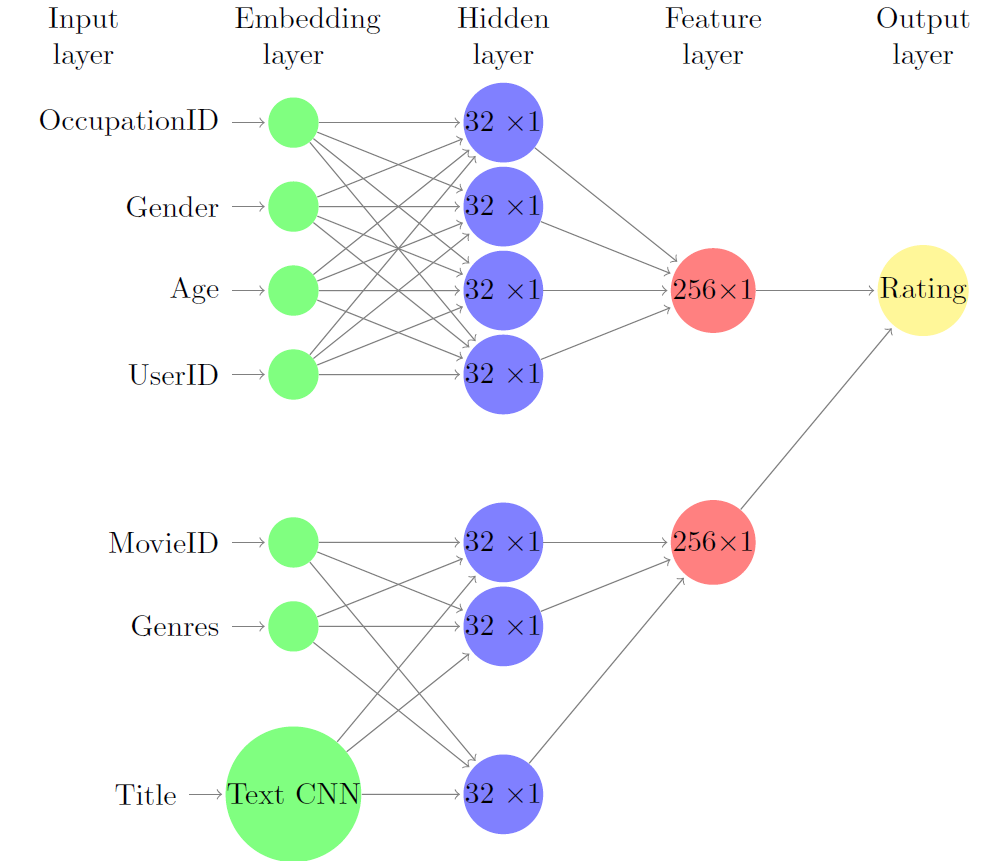
We have movie feature layer. The movie name here we have a text convlutional neural network to get features. First, we embed the movie ID, genres. And for movie names, we have a convolutional neural network for them. After that we have two full connecting layers. That last layer is the feature layer of movies.
For User information feature, we just embed all attributes and make two full connection layers. The last layer is our user feature layer.
By this two feature layer above, we predict rating scores for every movie by each user.

#### About embedding layers
Embedding layers can be used to deal with the sparse matrix problem in recommender systems. 

The word embeddings are very important in the world of Natural Language Processing. They allow us to capture relationships in language that are very difficult to capture otherwise. Embedding layers can be used to embed many more things than just words, as here we use this for all categorical data for importing data to the nueral network.


### Text Convolutional Neural Network
The implement come from this paper by Kim Yoon.
Convolutional Neural Networks for Sentence Classification
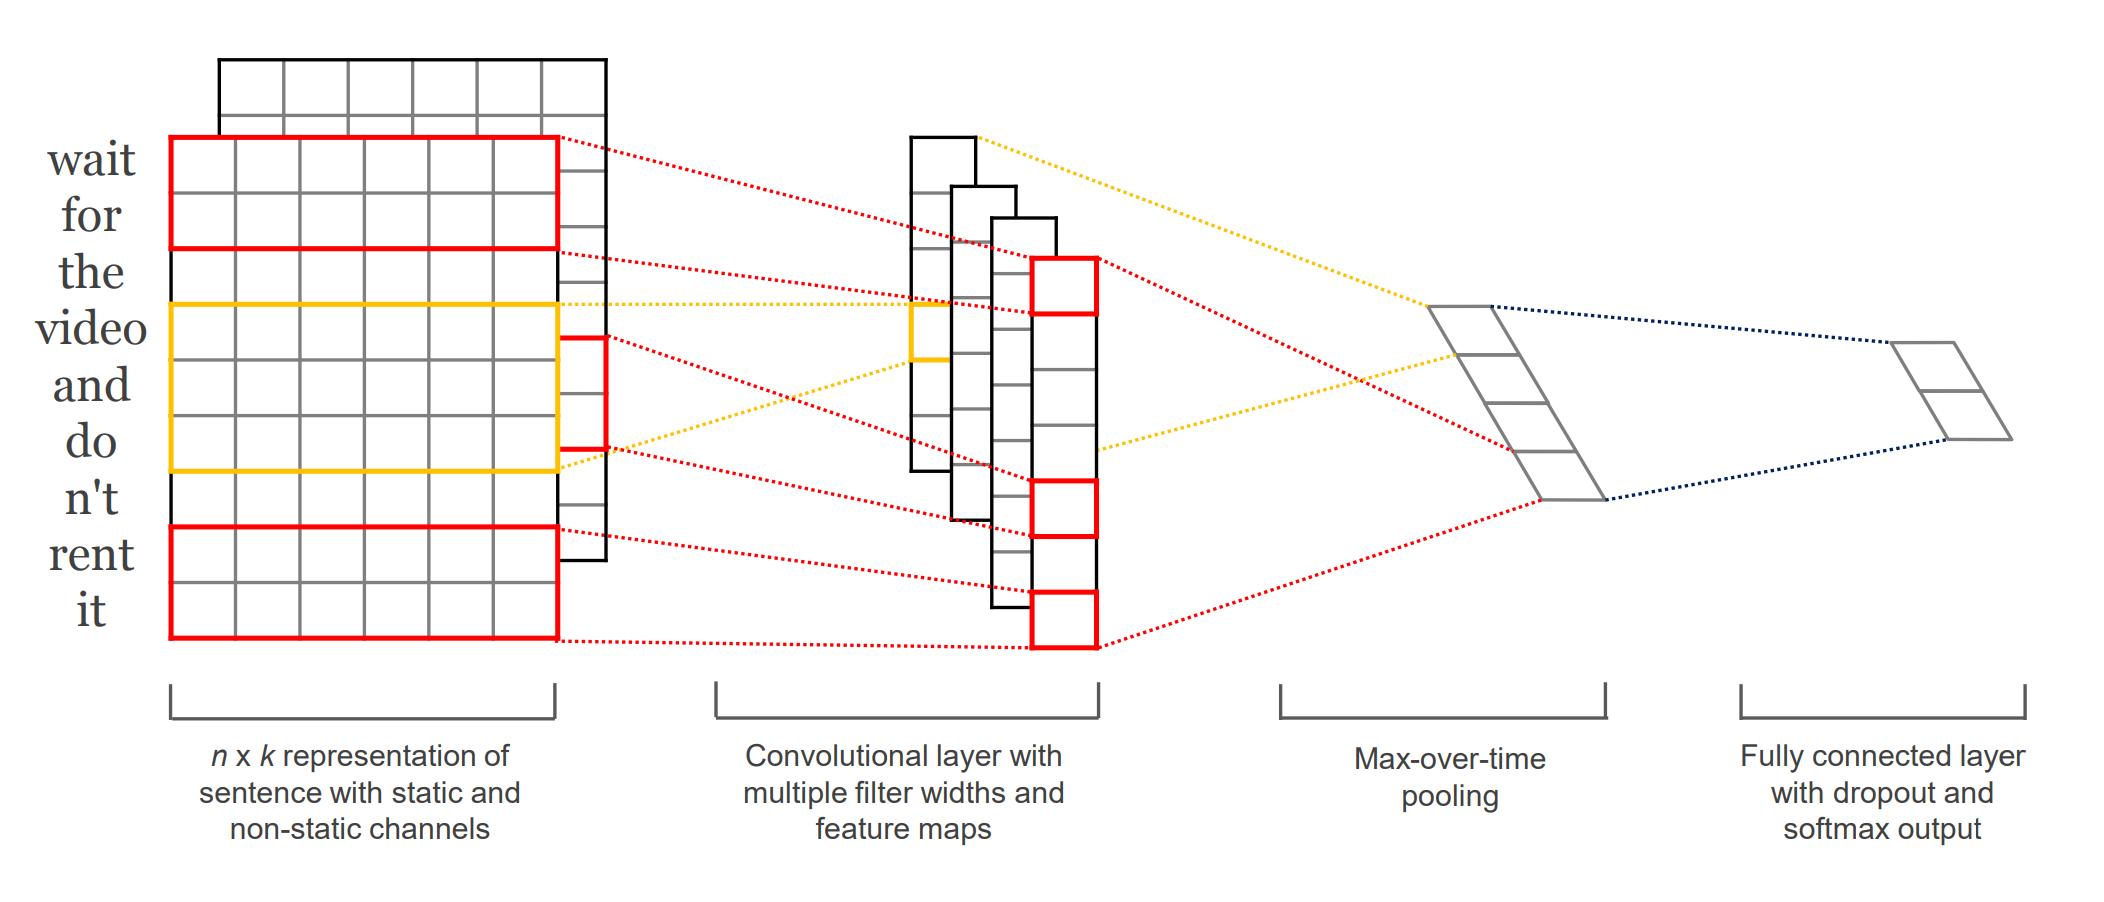
Picture from https://arxiv.org/abs/1408.5882


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import pickle
import re
from sklearn import cross_validation as cv
from collections import Counter
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import datetime

D:\ProgramData\Anaconda3\envs\FinalProject\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We use the tensorflow library for our neural network.
Pickle library for saving training data, and reading data. That can help us using dataset.
We use sci-kit learn for cross validation.
Pandas for data preparation.

In [2]:
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./users.dat', sep='::', header=None, names=users_title, engine = 'python')

In [3]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./movies.dat', sep='::', header=None, names=movies_title, engine = 'python')

In [4]:
ratings_title = ['UserID','MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')

Read three tables from the dataset files.

In [5]:
users.head()

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [8]:
dataforview = pd.merge(pd.merge(ratings, users), movies)
dataforview.head()

,UserID,MovieID,Rating,timestamps,Gender,Age,OccupationID,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


The rating table join two information tables, we can have a rating table with all attributes.

In [9]:
users_orig = users.values
movies_orig = movies.values

In [10]:
gender_map = {'F':0, 'M':1}
age_map = {1: 0, 18: 1, 25: 2, 35: 3, 45: 4, 50: 5, 56: 6}

Encode the gender info.
Gender is denoted by a "M" for male and "F" for female

Encode the ranges of ages.
- Age is chosen from the following ranges:

	*  1:  "Under 18"
	* 18:  "18-24"
	* 25:  "25-34"
	* 35:  "35-44"
	* 45:  "45-49"
	* 50:  "50-55"
	* 56:  "56+"
- To
	* 0:  "Under 18"
	* 1:  "18-24"
	* 2:  "25-34"
	* 3:  "35-44"
	* 4:  "45-49"
	* 5:  "50-55"
	* 6:  "56+"


In [11]:
users['Gender'] = users['Gender'].map(gender_map)
users['Age'] = users['Age'].map(age_map)

In [12]:
users = users.filter(regex='UserID|Gender|Age|OccupationID')
users.head()

,UserID,Gender,Age,OccupationID
0,1,0,0,10
1,2,1,6,16
2,3,1,2,15
3,4,1,4,7
4,5,1,2,20


The OccupationID is encoding like that (That is already done by movielens)
- Occupation is chosen from the following choices:

	*  0:  "other" or not specified
	*  1:  "academic/educator"
	*  2:  "artist"
	*  3:  "clerical/admin"
	*  4:  "college/grad student"
	*  5:  "customer service"
	*  6:  "doctor/health care"
	*  7:  "executive/managerial"
	*  8:  "farmer"
	*  9:  "homemaker"
	* 10:  "K-12 student"
	* 11:  "lawyer"
	* 12:  "programmer"
	* 13:  "retired"
	* 14:  "sales/marketing"
	* 15:  "scientist"
	* 16:  "self-employed"
	* 17:  "technician/engineer"
	* 18:  "tradesman/craftsman"
	* 19:  "unemployed"
	* 20:  "writer"

In [13]:
pattern = re.compile(r'^(.*)\((\d+)\)$')
title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))}
movies['Title'] = movies['Title'].map(title_map)

Remove the years after the movie names, avoid this effect our convolutional neural network.

The year information we might import to our neural network in our later research.

In [14]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story,Animation|Children's|Comedy
1,2,Jumanji,Adventure|Children's|Fantasy
2,3,Grumpier Old Men,Comedy|Romance
3,4,Waiting to Exhale,Comedy|Drama
4,5,Father of the Bride Part II,Comedy


In [15]:
genres_dic ={'<PAD>': 0,
 'Action': 1,
 'Adventure': 2,
 'Animation': 3,
 "Children's": 4,
 'Comedy': 5,
 'Crime': 6,
 'Documentary': 7,
 'Drama': 8,
 'Fantasy': 9,
 'Film-Noir': 10,
 'Horror': 11,
 'Musical': 12,
 'Mystery': 13,
 'Romance': 14,
 'Sci-Fi': 15,
 'Thriller': 16,
 'War': 17,
 'Western': 18}

Embedding the genres, and use PAD fill the blank.

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including year of release)
- Genres are pipe-separated and are selected from the following genres:

	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

In [16]:
genres_map = {val:[genres_dic[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

In [17]:
for key in genres_map:
    for cnt in range(max(genres_dic.values()) - len(genres_map[key])):
        genres_map[key].insert(len(genres_map[key]) + cnt,genres_dic['<PAD>'])
movies['Genres'] = movies['Genres'].map(genres_map)

In [18]:
movies.head()

,MovieID,Title,Genres
0,1,Toy Story,"[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,Jumanji,"[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,Grumpier Old Men,"[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,Waiting to Exhale,"[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,Father of the Bride Part II,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [19]:
title_set = set()
for val in movies['Title'].str.split():
    title_set.update(val)    
title_set.add('<PAD>')

Add all words in the movie names to our datasets.

In [20]:
title_dic = {val:ii for ii, val in enumerate(title_set)}

Make a dictionary for words in movie names.

In [21]:
title_count = 15
title_map = {val:[title_dic[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}

The longest movie names have 15 words in it.

In [22]:
for key in title_map:
    for cnt in range(title_count - len(title_map[key])):
        title_map[key].insert(len(title_map[key]) + cnt,title_dic['<PAD>'])    
movies['Title'] = movies['Title'].map(title_map)

In [23]:
movies.head()

,MovieID,Title,Genres
0,1,"[3415, 3833, 3506, 3506, 3506, 3506, 3506, 350...","[3, 4, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,"[2750, 3506, 3506, 3506, 3506, 3506, 3506, 350...","[2, 4, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,3,"[5052, 2157, 2534, 3506, 3506, 3506, 3506, 350...","[5, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,4,"[1642, 2537, 3299, 3506, 3506, 3506, 3506, 350...","[5, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,5,"[2264, 232, 582, 4773, 2979, 3994, 3506, 3506,...","[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [24]:
ratings = ratings.filter(regex='UserID|MovieID|Rating')

In [25]:
data = pd.merge(pd.merge(ratings, users), movies)
data.head()

,UserID,MovieID,Rating,Gender,Age,OccupationID,Title,Genres
0,1,1193,5,0,0,10,"[5212, 2177, 4967, 582, 2348, 2024, 3506, 3506...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2,1193,5,1,6,16,"[5212, 2177, 4967, 582, 2348, 2024, 3506, 3506...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,12,1193,4,1,2,12,"[5212, 2177, 4967, 582, 2348, 2024, 3506, 3506...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,15,1193,4,1,2,7,"[5212, 2177, 4967, 582, 2348, 2024, 3506, 3506...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,17,1193,5,1,5,1,"[5212, 2177, 4967, 582, 2348, 2024, 3506, 3506...","[8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Here we have done all the data preparations.

Then we can begin our data analysis by neural network.

In [26]:
dataforview.head()

,UserID,MovieID,Rating,timestamps,Gender,Age,OccupationID,Zip-code,Title,Genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama


In [27]:
target_fields = ['Rating']
features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]

In [28]:
features = features_pd.values
targets_values = targets_pd.values

The operations below can help us training model by reading data from hard disk.

In [29]:
pickle.dump((title_count, title_set, genres_dic, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

In [30]:
title_count, title_set, genres_dic, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

In [31]:
def save_params(params):
    pickle.dump(params, open('params.p', 'wb'))
def load_params():
    return pickle.load(open('params.p', mode='rb'))

In [32]:
embed_dim = 32
# Beacuse the things that we embed has relevant less values.
embed_dim_movieid = 32
# should not make this number greater, that will cause overfitting here.

Our embedding layer have 32 dimensions for every attribute. We might modify it and get a better MSE.

In [33]:
uid_count = max(features.take(0,1)) +1

In [34]:
gender_count  = max(features.take(2,1)) + 1 
gender_count 

2

In [35]:
age_count  = max(features.take(3,1)) + 1 
age_count

7

In [36]:
job_count  = max(features.take(4,1)) + 1
job_count

21

In [37]:
movie_id_count  = max(features.take(1,1)) +1

In [38]:
movie_categories_count  = max(genres_dic.values()) + 1 
movie_categories_count 

19

In [39]:
movie_title_max = len(title_set) 
movie_title_max

5215

In [40]:
combiner = "sum"
sentences_size = title_count 
window_sizes = {2, 3, 4, 5}
filter_num = 8
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

In [41]:
# Number of Epochs
num_epochs =10
# Batch Size
batch_size = 256
# 30% of neurons will be discard in every epochs.
dropout_keep = 0.7
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 50

save_dir = './save'

In [42]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

In [43]:
def user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_count, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_count, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_count, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_count, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

In [44]:
def user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2) 
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 256, tf.tanh)     
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 256])
    return user_combine_layer, user_combine_layer_flat

In [45]:
def movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_count, embed_dim_movieid], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

In [46]:
def movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_count, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    return movie_categories_embed_layer

In [47]:
def movie_cnn_layer(movie_titles):
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

In [48]:
def movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 256, tf.tanh)    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 256])
    return movie_combine_layer, movie_combine_layer_flat

In [49]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = user_embedding(uid, user_gender, user_age, user_job)
    user_combine_layer, user_combine_layer_flat = user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    movie_id_embed_layer = movie_id_embed_layer(movie_id)
    movie_categories_embed_layer = movie_categories_layers(movie_categories)
    pool_layer_flat, dropout_layer = movie_cnn_layer(movie_titles)
    movie_combine_layer, movie_combine_layer_flat = movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer)
    with tf.name_scope("inference"):
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)
    with tf.name_scope("loss"):
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

In [50]:
def get_batches(xs, ys, batch_size):
    for start in range(0, len(xs), batch_size):
        end = min(start + batch_size, len(xs))
        yield xs[start:end], ys[start:end]

In [51]:
losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
    
    loss_summary = tf.summary.scalar("loss", loss)
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        train_X,test_X, train_y, test_y = cv.train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories, 
                movie_titles: titles, 
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  
                movie_titles: titles,  
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))
    saver.save(sess, save_dir)  
    print('Model Trained and Saved')

Writing to C:\Users\Hao\Desktop\FinalProject\runs\1524978077

2018-04-29T00:01:22.627260: Epoch   0 Batch    0/3125   train_loss = 25.069
2018-04-29T00:01:24.466236: Epoch   0 Batch   50/3125   train_loss = 2.783
2018-04-29T00:01:26.302147: Epoch   0 Batch  100/3125   train_loss = 1.882
2018-04-29T00:01:28.198707: Epoch   0 Batch  150/3125   train_loss = 1.504
2018-04-29T00:01:30.042292: Epoch   0 Batch  200/3125   train_loss = 1.882
2018-04-29T00:01:31.895587: Epoch   0 Batch  250/3125   train_loss = 1.515
2018-04-29T00:01:33.707007: Epoch   0 Batch  300/3125   train_loss = 1.531
2018-04-29T00:01:35.525817: Epoch   0 Batch  350/3125   train_loss = 1.301
2018-04-29T00:01:37.344194: Epoch   0 Batch  400/3125   train_loss = 1.268
2018-04-29T00:01:39.160634: Epoch   0 Batch  450/3125   train_loss = 1.282
2018-04-29T00:01:40.968671: Epoch   0 Batch  500/3125   train_loss = 1.036
2018-04-29T00:01:42.793951: Epoch   0 Batch  550/3125   train_loss = 1.329
2018-04-29T00:01:44.612469: Epoch   0

2018-04-29T00:04:15.897181: Epoch   1 Batch 1525/3125   train_loss = 0.895
2018-04-29T00:04:17.664909: Epoch   1 Batch 1575/3125   train_loss = 1.076
2018-04-29T00:04:19.432582: Epoch   1 Batch 1625/3125   train_loss = 1.221
2018-04-29T00:04:21.200309: Epoch   1 Batch 1675/3125   train_loss = 1.029
2018-04-29T00:04:23.040174: Epoch   1 Batch 1725/3125   train_loss = 1.110
2018-04-29T00:04:24.805847: Epoch   1 Batch 1775/3125   train_loss = 1.059
2018-04-29T00:04:26.580574: Epoch   1 Batch 1825/3125   train_loss = 1.114
2018-04-29T00:04:28.369303: Epoch   1 Batch 1875/3125   train_loss = 1.145
2018-04-29T00:04:30.140011: Epoch   1 Batch 1925/3125   train_loss = 1.058
2018-04-29T00:04:31.913756: Epoch   1 Batch 1975/3125   train_loss = 0.997
2018-04-29T00:04:33.687473: Epoch   1 Batch 2025/3125   train_loss = 1.083
2018-04-29T00:04:35.526355: Epoch   1 Batch 2075/3125   train_loss = 1.180
2018-04-29T00:04:37.290050: Epoch   1 Batch 2125/3125   train_loss = 1.081
2018-04-29T00:04:39.07680

2018-04-29T00:07:09.068208: Epoch   2 Batch 3100/3125   train_loss = 1.076
2018-04-29T00:07:10.167098: Epoch   2 Batch   38/781   test_loss = 0.904
2018-04-29T00:07:10.476923: Epoch   2 Batch   88/781   test_loss = 0.767
2018-04-29T00:07:10.785743: Epoch   2 Batch  138/781   test_loss = 0.967
2018-04-29T00:07:11.096686: Epoch   2 Batch  188/781   test_loss = 0.871
2018-04-29T00:07:11.405535: Epoch   2 Batch  238/781   test_loss = 0.951
2018-04-29T00:07:11.713327: Epoch   2 Batch  288/781   test_loss = 0.926
2018-04-29T00:07:12.023151: Epoch   2 Batch  338/781   test_loss = 0.886
2018-04-29T00:07:12.330969: Epoch   2 Batch  388/781   test_loss = 0.961
2018-04-29T00:07:12.636782: Epoch   2 Batch  438/781   test_loss = 1.015
2018-04-29T00:07:12.949614: Epoch   2 Batch  488/781   test_loss = 0.941
2018-04-29T00:07:13.257432: Epoch   2 Batch  538/781   test_loss = 0.828
2018-04-29T00:07:13.567256: Epoch   2 Batch  588/781   test_loss = 0.854
2018-04-29T00:07:13.877080: Epoch   2 Batch  638/

2018-04-29T00:09:42.734040: Epoch   4 Batch  850/3125   train_loss = 0.940
2018-04-29T00:09:44.517784: Epoch   4 Batch  900/3125   train_loss = 0.879
2018-04-29T00:09:46.302530: Epoch   4 Batch  950/3125   train_loss = 0.861
2018-04-29T00:09:48.107328: Epoch   4 Batch 1000/3125   train_loss = 0.994
2018-04-29T00:09:49.892076: Epoch   4 Batch 1050/3125   train_loss = 0.831
2018-04-29T00:09:51.728961: Epoch   4 Batch 1100/3125   train_loss = 0.892
2018-04-29T00:09:53.510668: Epoch   4 Batch 1150/3125   train_loss = 0.885
2018-04-29T00:09:55.303461: Epoch   4 Batch 1200/3125   train_loss = 1.032
2018-04-29T00:09:57.086201: Epoch   4 Batch 1250/3125   train_loss = 0.937
2018-04-29T00:09:58.871757: Epoch   4 Batch 1300/3125   train_loss = 0.869
2018-04-29T00:10:00.650394: Epoch   4 Batch 1350/3125   train_loss = 0.823
2018-04-29T00:10:02.427091: Epoch   4 Batch 1400/3125   train_loss = 0.960
2018-04-29T00:10:04.228882: Epoch   4 Batch 1450/3125   train_loss = 0.943
2018-04-29T00:10:06.01165

2018-04-29T00:12:36.477346: Epoch   5 Batch 2425/3125   train_loss = 0.793
2018-04-29T00:12:38.269110: Epoch   5 Batch 2475/3125   train_loss = 0.898
2018-04-29T00:12:40.045834: Epoch   5 Batch 2525/3125   train_loss = 0.797
2018-04-29T00:12:41.831642: Epoch   5 Batch 2575/3125   train_loss = 0.782
2018-04-29T00:12:43.636467: Epoch   5 Batch 2625/3125   train_loss = 0.959
2018-04-29T00:12:45.484353: Epoch   5 Batch 2675/3125   train_loss = 0.843
2018-04-29T00:12:47.274139: Epoch   5 Batch 2725/3125   train_loss = 0.921
2018-04-29T00:12:49.063898: Epoch   5 Batch 2775/3125   train_loss = 0.893
2018-04-29T00:12:50.846641: Epoch   5 Batch 2825/3125   train_loss = 0.846
2018-04-29T00:12:52.637400: Epoch   5 Batch 2875/3125   train_loss = 0.922
2018-04-29T00:12:54.422145: Epoch   5 Batch 2925/3125   train_loss = 0.841
2018-04-29T00:12:56.207871: Epoch   5 Batch 2975/3125   train_loss = 0.792
2018-04-29T00:12:58.059796: Epoch   5 Batch 3025/3125   train_loss = 0.896
2018-04-29T00:12:59.87863

2018-04-29T00:15:10.403148: Epoch   7 Batch  175/3125   train_loss = 0.865
2018-04-29T00:15:12.189872: Epoch   7 Batch  225/3125   train_loss = 0.736
2018-04-29T00:15:13.974617: Epoch   7 Batch  275/3125   train_loss = 0.739
2018-04-29T00:15:15.751225: Epoch   7 Batch  325/3125   train_loss = 0.804
2018-04-29T00:15:17.520986: Epoch   7 Batch  375/3125   train_loss = 0.872
2018-04-29T00:15:19.296683: Epoch   7 Batch  425/3125   train_loss = 0.844
2018-04-29T00:15:21.082614: Epoch   7 Batch  475/3125   train_loss = 0.830
2018-04-29T00:15:22.910194: Epoch   7 Batch  525/3125   train_loss = 0.936
2018-04-29T00:15:24.691958: Epoch   7 Batch  575/3125   train_loss = 0.973
2018-04-29T00:15:26.539873: Epoch   7 Batch  625/3125   train_loss = 0.796
2018-04-29T00:15:28.314592: Epoch   7 Batch  675/3125   train_loss = 0.748
2018-04-29T00:15:30.102317: Epoch   7 Batch  725/3125   train_loss = 0.769
2018-04-29T00:15:31.874058: Epoch   7 Batch  775/3125   train_loss = 0.796
2018-04-29T00:15:33.64473

2018-04-29T00:18:06.467869: Epoch   8 Batch 1800/3125   train_loss = 0.775
2018-04-29T00:18:08.267652: Epoch   8 Batch 1850/3125   train_loss = 0.820
2018-04-29T00:18:10.057411: Epoch   8 Batch 1900/3125   train_loss = 0.700
2018-04-29T00:18:11.848175: Epoch   8 Batch 1950/3125   train_loss = 0.770
2018-04-29T00:18:13.638937: Epoch   8 Batch 2000/3125   train_loss = 0.989
2018-04-29T00:18:15.530965: Epoch   8 Batch 2050/3125   train_loss = 0.862
2018-04-29T00:18:17.361806: Epoch   8 Batch 2100/3125   train_loss = 0.821
2018-04-29T00:18:19.197688: Epoch   8 Batch 2150/3125   train_loss = 0.850
2018-04-29T00:18:20.982461: Epoch   8 Batch 2200/3125   train_loss = 0.773
2018-04-29T00:18:22.757181: Epoch   8 Batch 2250/3125   train_loss = 0.903
2018-04-29T00:18:24.546938: Epoch   8 Batch 2300/3125   train_loss = 0.835
2018-04-29T00:18:26.335667: Epoch   8 Batch 2350/3125   train_loss = 0.895
2018-04-29T00:18:28.122446: Epoch   8 Batch 2400/3125   train_loss = 0.882
2018-04-29T00:18:29.90919

2018-04-29T00:20:53.590584: Epoch   9 Batch  271/781   test_loss = 0.901
2018-04-29T00:20:53.912438: Epoch   9 Batch  321/781   test_loss = 0.894
2018-04-29T00:20:54.232288: Epoch   9 Batch  371/781   test_loss = 0.676
2018-04-29T00:20:54.553898: Epoch   9 Batch  421/781   test_loss = 0.822
2018-04-29T00:20:54.871743: Epoch   9 Batch  471/781   test_loss = 0.818
2018-04-29T00:20:55.189589: Epoch   9 Batch  521/781   test_loss = 0.847
2018-04-29T00:20:55.505749: Epoch   9 Batch  571/781   test_loss = 0.751
2018-04-29T00:20:55.822591: Epoch   9 Batch  621/781   test_loss = 0.833
2018-04-29T00:20:56.142442: Epoch   9 Batch  671/781   test_loss = 0.813
2018-04-29T00:20:56.461289: Epoch   9 Batch  721/781   test_loss = 0.762
2018-04-29T00:20:56.779134: Epoch   9 Batch  771/781   test_loss = 0.628
Model Trained and Saved


In [52]:
save_params((save_dir))
load_dir = load_params()

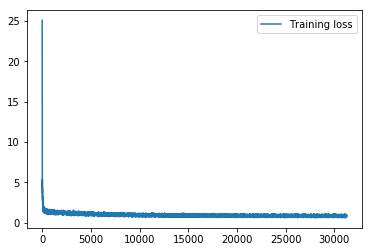

In [53]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

This is our training loss graph.
We can see, in the beginning we have a very high MSE, about 25. And decreasing very fast to about 1. And after 25000, we have the MSE about 0.8.

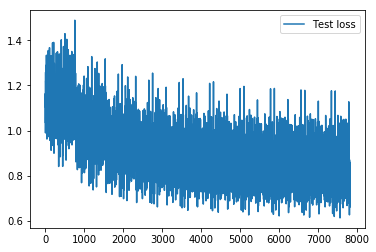

In [54]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

That is our testing loss in cross validation. The MSE of our training and testiung is very closed to each other. We can say that our model are not overfitting.

In [55]:
def get_tensors(loaded_graph):
    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") 
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat

In [56]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  
              movie_titles: titles,  
              dropout_keep_prob: 1}    
        # Get Prediction
        inference_val = sess.run([inference], feed)      
        return (inference_val)

In [57]:
rating_movie(571, 2018)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 4.05243349]], dtype=float32)]

After training, we have a martix of ratings for every movies and users.
We can check every movies rating score by every user.

In [58]:
loaded_graph = tf.Graph()  
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)
        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)
        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  
            movie_titles: titles, 
            dropout_keep_prob: 1}
        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)
pickle.dump((np.array(movie_matrics).reshape(-1, 256)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [59]:
loaded_graph = tf.Graph()  
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:
        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}
        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)
pickle.dump((np.array(users_matrics).reshape(-1, 256)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [60]:
def recommend_same_type_movie(movie_id_val, top_k = 5):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 256])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
        print("The movie you take：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("Recommend you to take：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != top_k:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])        
        return results

In [61]:
recommend_same_type_movie(1, 10)

INFO:tensorflow:Restoring parameters from ./save
The movie you take：[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
Recommend you to take：
0
[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
1440
[1467 'Salut cousin! (1996)' 'Comedy|Drama']
3682
[3751 'Chicken Run (2000)' "Animation|Children's|Comedy"]
2179
[2248 'Say Anything... (1989)' 'Comedy|Drama|Romance']
1156
[1172 'Cinema Paradiso (1988)' 'Comedy|Drama|Romance']
897
[909 'Apartment, The (1960)' 'Comedy|Drama']
2286
[2355 "Bug's Life, A (1998)" "Animation|Children's|Comedy"]
592
[596 'Pinocchio (1940)' "Animation|Children's"]
826
[837 'Matilda (1996)' "Children's|Comedy"]
3327
[3396 'Muppet Movie, The (1979)' "Children's|Comedy"]


{0, 592, 826, 897, 1156, 1440, 2179, 2286, 3327, 3682}

That is the movies that shared some genres with the movie we chose and have good ratings.

In [62]:
def recommend_your_favorite_movie(user_id_val, top_k = 10):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        probs_embeddings = (users_matrics[user_id_val-1]).reshape([1, 256])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())    
        print("Recommend：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != top_k:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        return results

In [63]:
recommend_your_favorite_movie(2018, 10)

INFO:tensorflow:Restoring parameters from ./save
Recommend：
1189
[1207 'To Kill a Mockingbird (1962)' 'Drama']
3238
[3307 'City Lights (1931)' 'Comedy|Drama|Romance']
3082
[3151 'Bat Whispers, The (1930)' 'Crime|Drama|Mystery']
1162
[1178 'Paths of Glory (1957)' 'Drama|War']
1132
[1148 'Wrong Trousers, The (1993)' 'Animation|Comedy']
910
[922 'Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)' 'Film-Noir']
847
[858 'Godfather, The (1972)' 'Action|Crime|Drama']
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
1240
[1260 'M (1931)' 'Crime|Film-Noir|Thriller']
1950
[2019 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai) (1954)'
 'Action|Drama']


{847, 910, 1132, 1162, 1189, 1240, 1950, 2836, 3082, 3238}

Here, We recommend movies that you might rate a high score based on your taste and attribute. 

In [64]:
# the movies of the guys who have take this movie have also take
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 5, num_of_movie =1):
    loaded_graph = tf.Graph()  
    with tf.Session(graph=loaded_graph) as sess:  
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 256])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
        print("The movie you take：{}".format(movies_orig[movieid2idx[movie_id_val]]))        
        print("Who like this moive: {}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 256])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
        p = np.argmax(sim, 1)
        print("The moive they also take：")
        results = set()
        while len(results) != num_of_movie:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])        
        return results

In [65]:
recommend_other_favorite_movie(1, 10,3)

INFO:tensorflow:Restoring parameters from ./save
The movie you take：[1 'Toy Story (1995)' "Animation|Children's|Comedy"]
Who like this moive: [[282 'M' 25 17 '94401']
 [1763 'M' 35 7 '76248']
 [371 'M' 18 4 '02141']
 [566 'M' 25 17 '92122']
 [2144 'M' 18 0 '46517']
 [5861 'F' 50 1 '98499']
 [4800 'M' 18 4 '80521']
 [4085 'F' 25 6 '79416']
 [2154 'M' 25 12 '68508']
 [3901 'M' 18 14 '85282']]
The moive they also take：
2836
[2905 'Sanjuro (1962)' 'Action|Adventure']
3366
[3435 'Double Indemnity (1944)' 'Crime|Film-Noir']
735
[745 'Close Shave, A (1995)' 'Animation|Comedy|Thriller']


{735, 2836, 3366}

This showed us the movies that people are similar with you like and with different genres. Add this in our recommendation can help us solve recommended too many movie with same genres.